In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import scipy
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats.stats import pearsonr

In [2]:
map_genre = {
    "Humor/Family": "Humor/Family/Romance",
    "Self-Help": "Self-Help",
    "Suspense/Mystery": "Suspense/Mystery",
    "Fantasy/Adventure": "Fantasy/Adventure",
    "Biography/Historical": "Biography/Historical/Memoir",
    "Romance": "Humor/Family/Romance",
    "Horror/Thriller": "Horror/Thriller",
    "Memoir": "Biography/Historical/Memoir",
    "Poetry/Novel": "Miscellaneous",
    "Historical/Fiction": "Biography/Historical/Memoir",
    "Novel": "Miscellaneous",
    "Non-Fiction": "Miscellaneous",
    "Folklore": "Fantasy/Adventure",
    "Travel": "Biography/Historical/Memoir",
    "Adventure": "Fantasy/Adventure",
    "Novel/Feminism": "Miscellaneous",
    "Historical/Family": "Biography/Historical/Memoir",
    "Children's/Humor": "Humor/Family/Romance",
    "Magical Realism/Historical": "Biography/Historical/Memoir",
    "Fantasy/Horror": "Fantasy/Adventure",
    "Political/Dystopian": "Fantasy/Adventure",
    "Self-help/Management": "Self-Help",
    "Historical/Adventure": "Fantasy/Adventure",
    "Thriller/Suspense": "Suspense/Mystery",
    "War/Romance": "Miscellaneous",
    "Science fiction/Adventure": "Fantasy/Adventure",
    "Literary fiction/Humor": "Humor/Family/Romance",
    "Adventure/Travel": "Biography/Historical/Memoir",
    "Philosophy/Nature": "Miscellaneous",
    "Satirical/War": "Miscellaneous",
    "Existential/Philosophical": "Miscellaneous",
    "Fantasy/Humor": "Fantasy/Adventure",
    "Mystery/Suspense": "Suspense/Mystery",
    "Thriller/Adventure": "Fantasy/Adventure",
    "Family/Humor": "Humor/Family/Romance",
    "Adventure/Fantasy": "Fantasy/Adventure",
    "Science Fiction/Thriller": "Fantasy/Adventure",
    "Science Fiction/Adventure": "Fantasy/Adventure",
    "Fantasy/Romance": "Fantasy/Adventure",
    "Science Fiction/Humor": "Fantasy/Adventure",
    "Thriller/Mystery": "Suspense/Mystery",
    "Horror/Suspense": "Horror/Thriller",
    "Non-fiction": "Miscellaneous",
    "Fiction": "Miscellaneous",
    "Non-fiction/Historical": "Biography/Historical/Memoir",
    "Philosophy": "Miscellaneous",
    "Cookbook": "Miscellaneous"
}

In [3]:
bookdataset =  pd.read_csv('BookDataset.csv')

for key, value in map_genre.items():
    bookdataset.loc[bookdataset["final genre"] == key, "final genre"] = value

In [4]:
def create_regression_plot(X, Y, Y_pred, x_label, y_label, axs):
    axs.scatter(X, Y, color="blue")
    axs.plot(X, Y_pred, color="red", linewidth=2)
    axs.ticklabel_format(style='plain', axis='y', scilimits=(0, 0))
    axs.ticklabel_format(style='sci', axis='x',scilimits=(0, 0))
    axs.set_xlabel(x_label)
    axs.set_ylabel(y_label)


def perform_regression_analysis(X, Y):

    ## Now we perform linear regression and plot it:
    r_model = linear_model.LinearRegression()

    ## Train the model to see the relation
    r_model.fit(X, Y)

    ## Predict the number of reviews
    predict_reviews_nums = r_model.predict(X)

    ## Mean square error
    print("Mean squared error: %.2f" % mean_squared_error(Y, predict_reviews_nums))

    ## r2_score
    print("R2 score: %.2f" % r2_score(Y, predict_reviews_nums))

    # Pearson correlation
    pearson_coef, p_value = pearsonr(X.flatten(), Y.flatten())
    print("Pearson correlation: %.4f" % pearson_coef)
    print("P-value: %.4f" % p_value)
    
    ## Weight of linear regression
    m = r_model.coef_
    ## Intersept of the line
    c = r_model.intercept_

    return predict_reviews_nums

In [5]:
# bookdataset =  pd.read_csv('BookDataset.csv')

ratings = bookdataset[['RatingDist5', 'RatingDist4', 'RatingDist3', 'RatingDist2',
       'RatingDist1']]
number_of_ratings = bookdataset[['RatingDistTotal']].to_numpy().reshape(-1,1)

## Perform regression analysis by taking standard deviation of ratings as "Controversy Score"
def do_std_dev_analysis(ratings, number_of_ratings, plot_axs, plot_enable=False, ylabel = "Number of ratings -->"):
    ratings_std_dev = np.std(ratings, axis=1).to_numpy().reshape(-1,1)
    predictions = perform_regression_analysis(ratings_std_dev, number_of_ratings)
    
    if(plot_enable):
        create_regression_plot(ratings_std_dev, number_of_ratings, predictions, "Standard deviation of ratings -->", ylabel, plot_axs)

## Perform regression analysis by taking difference between mean and median of ratings as "Controversy Score"  
def do_mean_median_analysis(ratings, number_of_ratings, plot_axs, plot_enable=False, ylabel = "Number of ratings -->"):
    ratings_median = np.median(ratings, axis=1).reshape(-1,1)
    ratings_mean = np.mean(ratings, axis=1).to_numpy().reshape(-1,1)

    ratings_diff = abs(ratings_median - ratings_mean)

    predictions = perform_regression_analysis(ratings_diff, number_of_ratings)
    
    if(plot_enable):
        create_regression_plot(ratings_diff, number_of_ratings, predictions,"||Mean - Median|| -->", ylabel, plot_axs);


## Perform regression analysis by taking ratio of 5 star to 1 star as "Controversy Score"
def do_ratio_analysis(ratings, number_of_ratings, plot_axs, plot_enable=False, ylabel = "Number of ratings -->"):
    ratings_np = ratings.to_numpy()
    ratio_5_1 = (ratings_np[:,0] / ratings_np[:,4]).reshape(-1, 1)
    predictions = perform_regression_analysis(ratio_5_1, number_of_ratings)
    
    if(plot_enable):
        create_regression_plot(ratio_5_1, number_of_ratings, predictions, "Ratio of 5star to 1star -->", ylabel, plot_axs)


Mean squared error: 59938014756.63
R2 score: 0.90
Pearson correlation: 0.9469
P-value: 0.0000


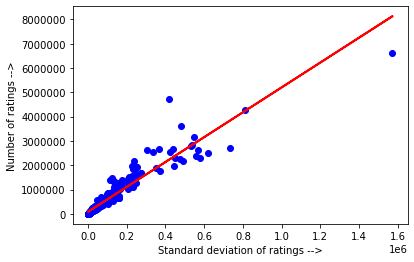

In [6]:
fig, axs = plt.subplots()
do_std_dev_analysis(ratings, number_of_ratings, axs, True)

Mean squared error: 237766736933.68
R2 score: 0.59
Pearson correlation: 0.7681
P-value: 0.0000


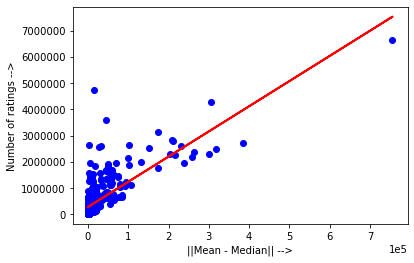

In [7]:
fig, axs = plt.subplots()
do_mean_median_analysis(ratings, number_of_ratings, axs, True)

Mean squared error: 576395305090.11
R2 score: 0.01
Pearson correlation: 0.0770
P-value: 0.1195


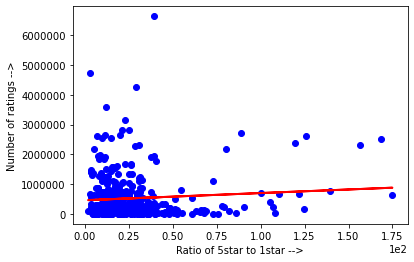

In [8]:
fig, axs = plt.subplots()
do_ratio_analysis(ratings, number_of_ratings, axs, True)

HUMOR/FAMILY/ROMANCE
Mean squared error: 12580003699.11
R2 score: 0.96
Pearson correlation: 0.9776
P-value: 0.0000

SELF-HELP
Mean squared error: 4012596315.25
R2 score: 0.97
Pearson correlation: 0.9859
P-value: 0.0000

SUSPENSE/MYSTERY
Mean squared error: 58974549346.61
R2 score: 0.94
Pearson correlation: 0.9673
P-value: 0.0000

FANTASY/ADVENTURE
Mean squared error: 125730898825.95
R2 score: 0.88
Pearson correlation: 0.9361
P-value: 0.0000

BIOGRAPHY/HISTORICAL/MEMOIR
Mean squared error: 34334293074.29
R2 score: 0.93
Pearson correlation: 0.9621
P-value: 0.0000

HORROR/THRILLER
Mean squared error: 2721049317.99
R2 score: 0.98
Pearson correlation: 0.9891
P-value: 0.0000

MISCELLANEOUS
Mean squared error: 2497237149.46
R2 score: 0.99
Pearson correlation: 0.9944
P-value: 0.0000



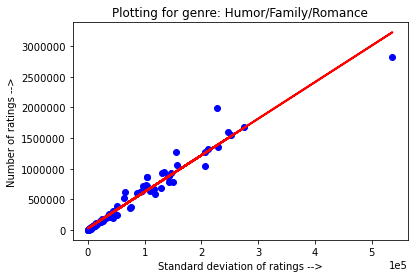

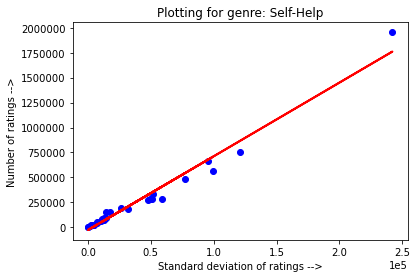

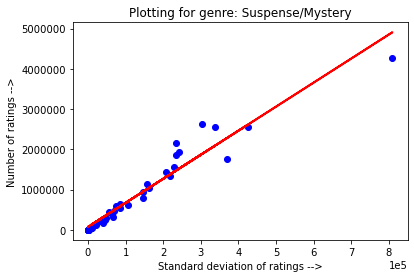

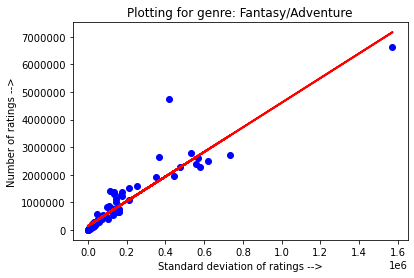

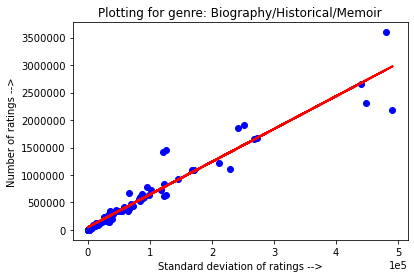

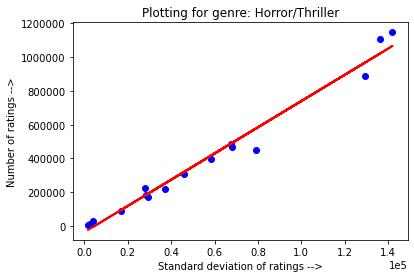

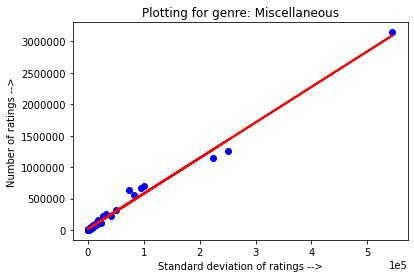

In [9]:
## Per genre analysis. We only plot std-deviation as it gives best relations

unique_values = bookdataset["final genre"].unique()

# fig, axs = plt.subplots(7,1)
count = 0
for genre in unique_values:
    dataSubset = bookdataset.loc[bookdataset["final genre"] == genre]
    ratings_subset = dataSubset[['RatingDist5', 'RatingDist4', 'RatingDist3', 'RatingDist2',
       'RatingDist1']]
    number_of_ratings_subset = dataSubset[['RatingDistTotal']].to_numpy().reshape(-1,1)
    
    string_print = "Plotting for genre: " + str(genre)
    fig, axs = plt.subplots()
    axs.set_title(string_print)
    print(genre.upper())
    do_std_dev_analysis(ratings_subset, number_of_ratings_subset, axs, True)
    print()
    

HUMOR/FAMILY/ROMANCE
Mean squared error: 0.03
R2 score: 0.03
Pearson correlation: 0.1833
P-value: 0.0952

SELF-HELP
Mean squared error: 0.04
R2 score: 0.01
Pearson correlation: 0.1048
P-value: 0.5885

SUSPENSE/MYSTERY
Mean squared error: 0.03
R2 score: 0.01
Pearson correlation: 0.0986
P-value: 0.5344

FANTASY/ADVENTURE
Mean squared error: 0.05
R2 score: 0.16
Pearson correlation: 0.3951
P-value: 0.0000

BIOGRAPHY/HISTORICAL/MEMOIR
Mean squared error: 0.05
R2 score: 0.06
Pearson correlation: 0.2519
P-value: 0.0233

HORROR/THRILLER
Mean squared error: 0.01
R2 score: 0.30
Pearson correlation: -0.5443
P-value: 0.0293

MISCELLANEOUS
Mean squared error: 0.05
R2 score: 0.08
Pearson correlation: 0.2836
P-value: 0.0326



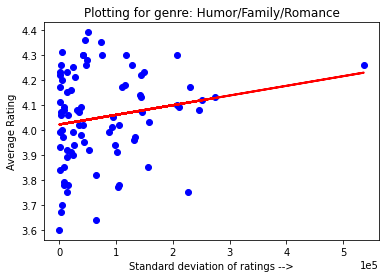

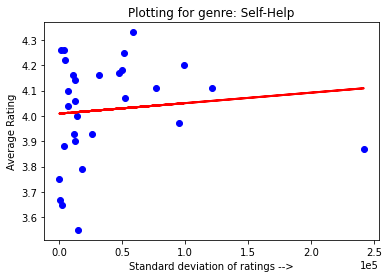

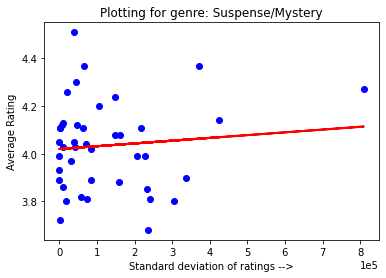

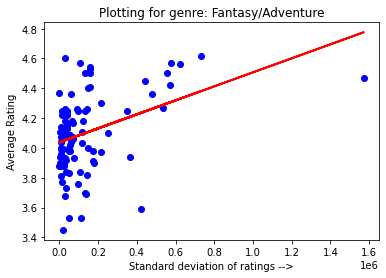

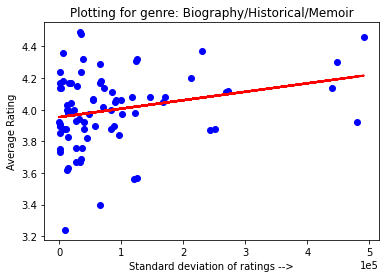

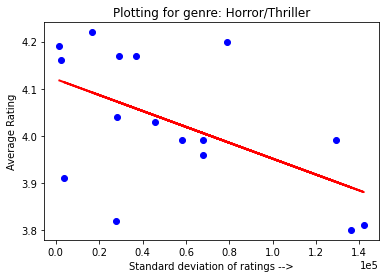

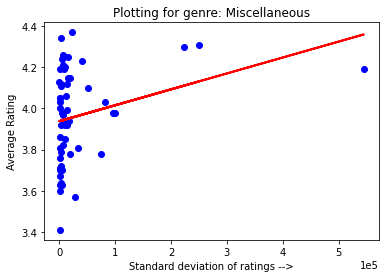

In [10]:
for genre in unique_values:
    dataSubset = bookdataset.loc[bookdataset["final genre"] == genre]
    ratings_subset = dataSubset[['RatingDist5', 'RatingDist4', 'RatingDist3', 'RatingDist2',
       'RatingDist1']]
    number_of_ratings_subset = dataSubset[['Rating']].to_numpy().reshape(-1,1)
    
    string_print = "Plotting for genre: " + str(genre)
    fig, axs = plt.subplots()
    axs.set_title(string_print)
    print(genre.upper())
    do_std_dev_analysis(ratings_subset, number_of_ratings_subset, axs, True, "Average Rating")
    print()

HUMOR/FAMILY/ROMANCE
Mean squared error: 70669331.60
R2 score: 0.37
Pearson correlation: 0.6113
P-value: 0.0000

SELF-HELP
Mean squared error: 1462815.61
R2 score: 0.01
Pearson correlation: -0.1071
P-value: 0.5805

SUSPENSE/MYSTERY
Mean squared error: 49780237.77
R2 score: 0.01
Pearson correlation: 0.1071
P-value: 0.4997

FANTASY/ADVENTURE
Mean squared error: 117116646.12
R2 score: 0.02
Pearson correlation: 0.1552
P-value: 0.1212

BIOGRAPHY/HISTORICAL/MEMOIR
Mean squared error: 109892456.97
R2 score: 0.13
Pearson correlation: 0.3589
P-value: 0.0010

HORROR/THRILLER
Mean squared error: 12814548.10
R2 score: 0.00
Pearson correlation: 0.0640
P-value: 0.8139

MISCELLANEOUS
Mean squared error: 1211558.60
R2 score: 0.00
Pearson correlation: 0.0164
P-value: 0.9038



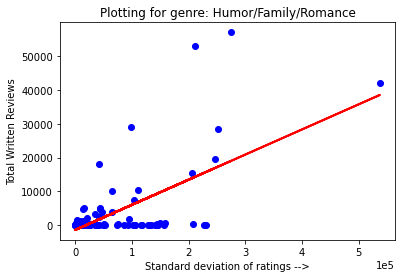

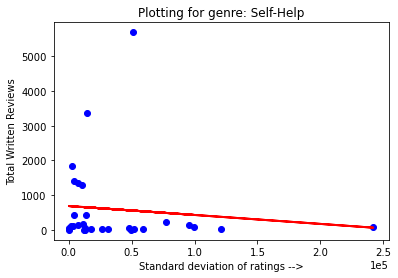

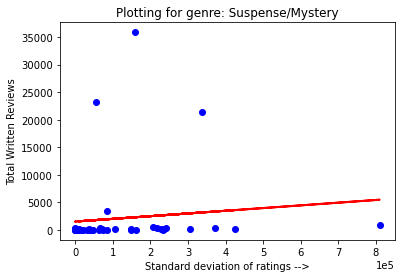

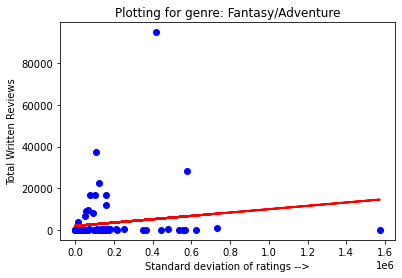

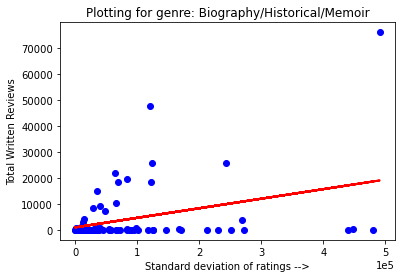

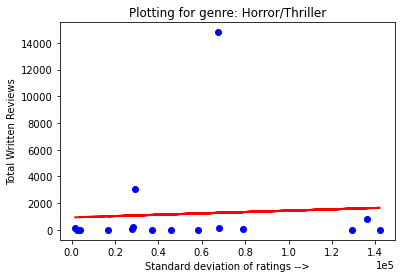

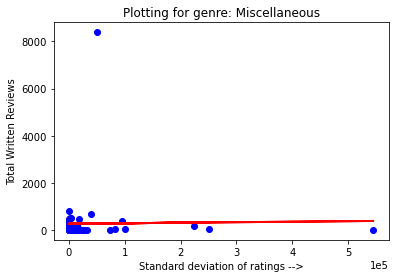

In [11]:
for genre in unique_values:
    dataSubset = bookdataset.loc[bookdataset["final genre"] == genre]
    ratings_subset = dataSubset[['RatingDist5', 'RatingDist4', 'RatingDist3', 'RatingDist2',
       'RatingDist1']]
    number_of_ratings_subset = dataSubset[['CountsOfReview']].to_numpy().reshape(-1,1)
    
    string_print = "Plotting for genre: " + str(genre)
    fig, axs = plt.subplots()
    axs.set_title(string_print)
    print(genre.upper())
    do_std_dev_analysis(ratings_subset, number_of_ratings_subset, axs, True, "Total Written Reviews")
    print()
    #do_ratio_analysis(ratings_subset, number_of_ratings_subset, axs, True)
    #do_mean_median_analysis(ratings_subset, number_of_ratings_subset, axs, True)
    